# Forward Modeling Donuts
*David Thomas and Emily Li 2019/07/10*

**Abstract**: This is the seminal notebook in this series. We combine elements from the previous three notebooks to implement forward modeling and use it to determine the wavefront for a simulated donut.

**Table of Contents:**
- [Forward Modeling A Donut](#Forward-Modeling-A-Donut)
- [Comparing Foward Modeled And Raytraced Donuts](#Comparing-Foward-Modeled-And-Raytraced-Donuts)
- [Developing Wavefront Estimation Pipeline](#Developing-Wavefront-Estimation-Pipeline)

## Forward Modeling A Donut

We use the fraunhofer integral to convert the wavefront $W$ over the pupil parameterized by $u$ to the image intensity in the focal plane $I$ over the focal plane parameterized by $x$.

$$I(x) = \left|F\{P(u)\exp(2\pi i W(u) / \lambda)\}\right|^2$$

$P$ is the pupil function, which is 1 over the pupil region and 0 elsewhere. For our work, we can treat this equation as a black box. The derivation can be found in Chapter 4 of Goodman's Fourier Optics if you are interested, but it takes a bit of work to get there and in my opinion offers poor return on invested time. Some of the components of this equation may look familiar from the previous notebooks. $W$ is the output of the opd function we worked on in [RaytracingAndFittingTheOPD.ipynb](https://github.com/davidthomas5412/ForwardModelingLSSTDonuts/blob/master/notebooks/RaytracingAndFittingTheOPD.ipynb), and $P$ is the donut mask we have been using since [ZernikePolynomials.ipynb](https://github.com/davidthomas5412/ForwardModelingLSSTDonuts/blob/master/notebooks/ZernikePolynomials.ipynb). Let's start by importing the usual packages and copying functions over from previous notebooks.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import batoid
import yaml
from batoid.utils import fieldToDirCos
import galsim

We copy over the aforementioned opd function. This function is based on batoid.wavefront but has some slight differences that have to do with how the wavefront or OPD is defined. Because these functions might get a lot of use this summer, we comment our functions in accordance with [numpy docstring syntax](https://numpydoc.readthedocs.io/en/latest/format.html).

In [2]:
def opd(telescope, theta_x=0, theta_y=0, wavelength=500e-9, nx=256, projection='zemax', lattice=False):
    """
    Computes the optical path difference, or wavefront, of a telescope.
    
    Parameters
    ----------
    telescope: batoid.Optic
        The telescope for which to compute wavefront.
    theta_x, theta_y : float
        Field of incoming rays (gnomonic projection). Default to 0.
    wavelength: float
        The Wavelength of light. Defaults to 500e-9 = 500nm.
    nx: int
        Number of grid points in each dimension. Defaults to 2048.
    projection : {'postel', 'zemax', 'gnomonic', 'stereographic', 'lambert', 'orthographic'}
        Projection used to convert field angle to direction cosines.
    lattice : bool, optional
        If true, then decenter the grid so it spans (-N/2, N/2+1), as appropriate
        for Fourier transforms.
        
    Returns
    -------
    batoid.Lattice
        The wavefront, or optical path difference, of the telescope.
    """
    flux = 1
    dirCos = fieldToDirCos(theta_x, theta_y, projection=projection)
    rays = batoid.rayGrid(
        telescope.dist/dirCos[2], telescope.pupilSize,
        dirCos[0], dirCos[1], -dirCos[2],
        nx, wavelength, flux, telescope.inMedium, lattice=lattice)
    
    # chief ray index.  works if lattice=True and nx is even,
    # or if lattice=False and nx is odd
    cridx = (nx//2)*nx+nx//2
    
    telescope.traceInPlace(rays, outCoordSys=batoid.globalCoordSys)
    spherePoint = rays[cridx].r
    
    # We want to place the vertex of the reference sphere one radius length away from the
    # intersection point.  So transform our rays into that coordinate system.
    radius = np.hypot(telescope.sphereRadius, np.hypot(spherePoint[0], spherePoint[1]))
    transform = batoid.CoordTransform(
            batoid.globalCoordSys, batoid.CoordSys(spherePoint+np.array([0,0,radius])))
    transform.applyForwardInPlace(rays)

    sphere = batoid.Sphere(-radius)
    sphere.intersectInPlace(rays) 
    t0 = rays[cridx].t
    arr = np.ma.masked_array(t0-rays.t, mask=rays.vignetted).reshape(nx, nx)

    primitiveVectors = np.vstack([[telescope.pupilSize/nx, 0], [0, telescope.pupilSize/nx]])
    return batoid.Lattice(arr, primitiveVectors)

We also copy over a loadTelescope function which provides a convenient way to get a new telescope with the detector offset. 

In [3]:
def loadTelescope(offset=1.5e-3):
    """
    Convenience function for loading a telescope.
    
    Parameters
    ----------
    offset: float
        The offset of the detector. Defaults to 1.5e-3 = 1.5mm.
    
    Returns
    -------
    batoid.Optic
        The loaded telescope.
    """
    LSST_g_fn = os.path.join(batoid.datadir, "LSST", "LSST_g.yaml")
    config = yaml.safe_load(open(LSST_g_fn))
    telescope = batoid.parse.parse_optic(config['opticalSystem'])
    telescope = telescope.withGloballyShiftedOptic('LSST.LSSTCamera.Detector', [0, 0, offset])
    return telescope

Next, we dive right in and implement the fraunhofer integral described above. This code is very similar to batoid.fftPSF but has some slight differences with the default values and the units of the wavefront. Lines 25-32 implement the math with numpy arrays. Then in lines 34-36 we determine the grid, or scale, of the output. Why do we need this second part? It is actually a trick to improve performance. np.fft.fft2 implements the 2-dimensional fast fourier transform. This has a runtime complexity of $\mathcal{O}(n_x^2\log(n_x))$ as opposed to $\mathcal{O}(n_x^4)$ for a naive implementation of the fourier transform. In order to apply this discrete version to our problem, we must add a constraint between the $u$ and $x$ above. The second part of the code determines $x$ from $u$. Josh Meyer's has a great [note](https://github.com/jmeyers314/5planes/blob/master/5planes.pdf) that describes this further. However, for our work, the key takeaway is that once we do the math we have to compute the grid lattice, or scale.

In [4]:
def fftPSF(telescope, theta_x=0, theta_y=0, wavelength=500e-9, nx=2500, projection='zemax', pad_factor=1):
    """Compute PSF using FFT.

    Parameters
    ----------
    telescope : batoid.Optic
        Telescope for which to compute wavefront.
    theta_x, theta_y : float
        Field of incoming rays (gnomonic projection). Defaults to zero.
    wavelength : float
        Wavelength of incoming rays. Defaults to 500e-9 = 500 nm.
    nx : int, optional
        Size of ray grid to generate to compute wavefront.  Defaults to 2500.
    projection : {'postel', 'zemax', 'gnomonic', 'stereographic', 'lambert', 'orthographic'}
        Projection used to convert field angle to direction cosines.
    pad_factor : int, optional
        Factor by which to pad pupil array.  Defaults to 1.

    Returns
    -------
    psf : batoid.Lattice
        A batoid.Lattice object containing the relative PSF values and
        the primitive lattice vectors of the focal plane grid.
    """
    wf = opd(telescope, theta_x, theta_y, wavelength, nx, projection=projection, lattice=True) 
    wfarr = wf.array / wavelength
    pad_size = nx*pad_factor
    expwf = np.zeros((pad_size, pad_size), dtype=np.complex128)
    start = pad_size//2-nx//2
    stop = pad_size//2+nx//2
    expwf[start:stop, start:stop][~wfarr.mask] = np.exp(2j*np.pi*wfarr[~wfarr.mask])
    psf = np.abs(np.fft.fftshift(np.fft.fft2(expwf)))**2

    primitiveU = wf.primitiveVectors
    primitiveK = batoid.psf.dkdu(telescope, theta_x, theta_y, wavelength, projection=projection).dot(primitiveU)
    primitiveX = np.vstack(batoid.psf.reciprocalLatticeVectors(primitiveK[0], primitiveK[1], pad_size))

    return batoid.Lattice(psf, primitiveX)

Let's run a snippet that combines everything. The %%time command is a magic jupyter command that, perhaps not too surprisingly, times the cell.

In [5]:
%%time
telescope = loadTelescope()
psf = fftPSF(telescope, theta_x=0, theta_y=0, wavelength=500e-9, nx=2500, pad_factor=1, projection='zemax')

CPU times: user 29.4 s, sys: 715 ms, total: 30.1 s
Wall time: 10.7 s


~13 second wall time on my machine, not too bad. Let's see what it looks like.

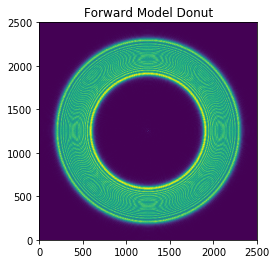

In [6]:
plt.title('Forward Model Donut')
plt.imshow(psf.array, origin='lower');

There are a lot of weird ring-like artifacts. These kinds of artifacts are common when working with fourier transforms. Another key property of the fourier transform is that the boundary conditions are periodic. So if we make our nx smaller, then the regions of the donuts that fall outside will get folded back onto the other side. Let's look at some examples.

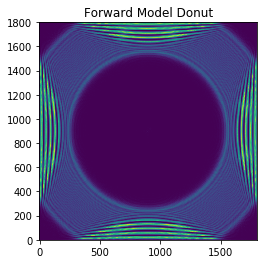

In [7]:
telescope = loadTelescope()
psf = fftPSF(telescope, theta_x=0, theta_y=0, wavelength=500e-9, nx=1800, pad_factor=1, projection='zemax')
plt.title('Forward Model Donut')
plt.imshow(psf.array, origin='lower');

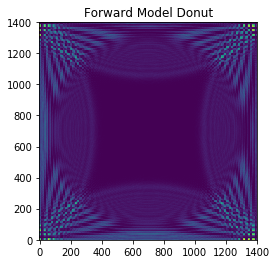

In [8]:
psf = fftPSF(telescope, theta_x=0, theta_y=0, wavelength=500e-9, nx=1400, pad_factor=1, projection='zemax')
plt.title('Forward Model Donut')
plt.imshow(psf.array, origin='lower');

One way this could come up is if we introduce perturbations that put the donuts more out of focus. Then they could be larger than our nx=2500 grid covers and produce images similar to the ones above. Now you will know what the issue is. 

**Problem 1:** Run the fftPSF with different values of nx and store the runtime. You can use the built-in python [time module](https://docs.python.org/3/library/time.html) for this (ex: time.time()). Then plot the runtimes against nx. Does this match the algorithmic complexity?

In [9]:
# TODO: your code and analysis here.

**Problem 2:** Introduce your favorite perturbation to a telescope and see how the fftPSF output changes.

In [10]:
# TODO: your code and analysis here.

## Comparing Foward Modeled And Raytraced Donuts

We borrow our code from [SimulatingDonutImages.ipynb](https://github.com/davidthomas5412/ForwardModelingLSSTDonuts/blob/master/notebooks/SimulatingDonutImages.ipynb) and clean it up.

In [11]:
def raytraceDonut(telescope, nphot=int(1e7), theta_x=0, theta_y=0, wavelength=500e-9):
    """Simulate a donut image by raytracing photons through telescope.
    
    Parameters
    ----------
    telescope: batoid.Optic
        The telescope to raytrace through.
    nphot: int
        The number of photons to raytrace. Defaults to 1 million.
    theta_x: float
        The x field position. Defaults to 0.
    theta_y: float
        The y field position. Defaults to 0.
    wavelength: float
        The wavelength of light to use. Defaults to 500e-9 = 500 nm.
    
    Returns
    -------
    batoid.Lattice
        The donut image.
    """
    flux = 1
    xcos, ycos, zcos = batoid.utils.gnomonicToDirCos(theta_x, theta_y)
    rays = batoid.uniformCircularGrid(
        telescope.dist, 
        telescope.pupilSize/2, 
        telescope.pupilSize*telescope.pupilObscuration/2,
        xcos, ycos, -zcos,
        nphot, wavelength, flux,
        telescope.inMedium)
    telescope.traceInPlace(rays)
    rays.trimVignettedInPlace()
    
    xcent, ycent = np.median(rays.x), np.median(rays.y)
    pix = 10e-6
    width = 192 * pix
    
    xedges = np.arange(xcent-width/2, xcent+width/2, pix)
    yedges = np.arange(ycent-width/2, ycent+width/2, pix)
    # flip here because 1st dimension corresponds to y-dimension in bitmap image
    result, _, _ = np.histogram2d(rays.y, rays.x, bins=[yedges, xedges])
    
    primitiveX = np.array([[pix,0],[0,pix]])
    return batoid.Lattice(result, primitiveX)

Let's time it.

In [12]:
%%time
telescope = loadTelescope()
ans = raytraceDonut(telescope)

CPU times: user 47.5 s, sys: 827 ms, total: 48.3 s
Wall time: 16.5 s


~20 seconds on my machine, not bad.

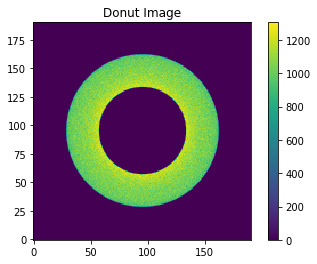

In [13]:
plt.title('Donut Image')
plt.imshow(ans.array, origin='lower')
plt.colorbar();

What do the lattice vectors (lattice.primitiveVectors) look like? The code above gives it away. They are unit vectors with the length of an LSST pixel.

In [14]:
print('Lattice Primitive Vectors:', ans.primitiveVectors)

Lattice Primitive Vectors: [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]]


The natural thing we will want to do is compare the donuts produced by these two methods. However the sizes and lattice primitive vectors are different. We will have to correct for this before we are able to compare them. The functions below make these corrections. First, we must "re-pixelize" the fftPSF image with pixels that are LSST sized. We will also have to update the primitive vectors accordingly. This is what lsstPixels does. Next we extract the arrays of values, normalize them, and align them with compare. Finally we add a plot function to make comparisons convenient. 

In [15]:
from scipy.interpolate import interp2d
from scipy.signal import correlate
from mpl_toolkits.axes_grid1 import make_axes_locatable

def lsstPixels(lattice, pix=10e-6):
    """
    Pixelizes the lattice so that pixels correspond to LSST pixels.
    
    Parameters
    ----------
    lattice: batoid.Lattice
        The psf lattice to pixelize.
    pix: float
        The size in meters of an LSST pixel.
        
    Returns
    -------
    lattice: batoid.Lattice
        The re-pixelized lattice.
    
    Note
    ----
    We assume lattice1 has cartesian grid vectors.
    """
    nx, ny = lattice.array.shape
    dx, dy = lattice.primitiveVectors[0,0], lattice.primitiveVectors[1,1]
    z = lattice.array
    if dx < 0:
        z = z[::-1,:]
        dx = np.abs(dx)
    if dy < 0:
        z = z[:,::-1]
        dy = np.abs(dy)
    x = np.arange(nx) * dx
    y = np.arange(ny) * dy
    
    interp = interp2d(x, y, z)
    xprime = np.arange(nx * dx // pix) * pix
    yprime = np.arange(ny * dy // pix) * pix

    arr = interp(xprime, yprime)
    primitiveVectors = np.eye(2) * pix
    return batoid.Lattice(arr, primitiveVectors)

def compare(donutLattice, psfLattice):
    """
    Re-pixelizes, normalizes, and centers lattices so that they can be compared on the same footing.
    
    Parameters
    ----------
    donutLattice: batoid.Lattice
        The donut lattice.
    psfLattice: batoid.Lattice
        The psf lattice.
        
    Returns
    -------
    numpy.ndarray, numpy.ndarray
        The psf and donut images.
    
    Notes
    -----
    Assume psf is larger.
    """
    psfprime = lsstPixels(psfLattice)
    
    psf = psfprime.array
    donut = donutLattice.array
    
    # first pad smaller array so that both are the same size
    psf_nx = psf.shape[0]
    donut_nx = donut.shape[0]
    nx = max(psf_nx, donut_nx)
    larger = np.zeros((nx,nx))
    if psf_nx > donut_nx:
        larger[:donut_nx,:donut_nx] = donut
        donut = larger
    else:
        larger[:psf_nx,:psf_nx] = psf
        psf = larger
        
    # smart way to center them
    center = nx // 2
    corr = correlate(psf, donut, mode='same')
    idx = np.argmax(corr)
    xmatch = (idx // nx)
    ymatch = (idx % nx)
    dx = center - xmatch
    dy = center - ymatch
    psf = np.roll(np.roll(psf, dx, axis=0), dy, axis=1)
    
    donut /= donut.sum()
    psf /= psf.sum()
    
    return donut, psf

def plotDonuts(donut, psf):
    """
    Plots the images and their difference.
    
    Parameters
    ----------
    donut: numpy.ndarray
        The donut image.
    psf: numpy.ndarray
        The psf image.
    """
    fig, axes = plt.subplots(1,3)
    for i,(title, img) in enumerate([('Donut', donut), 
                                     ('PSF', psf),
                                     ('Diff', donut-psf)]):
        # make image
        ax = axes[i]
        ax.set_title(title)
        im = ax.imshow(img, origin='lower')
        ax.axis('off')
        
        # set up colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cb = fig.colorbar(im, cax=cax, orientation='vertical', format='%.0e')
        cax.tick_params(labelsize=7)
    fig.set_size_inches((9,3))

Let's put everything together.

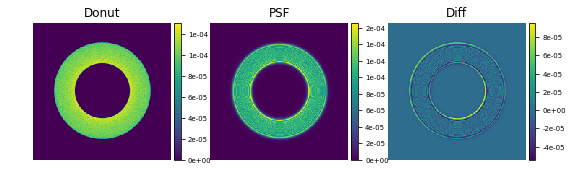

In [16]:
telescope = loadTelescope()
donutLattice = raytraceDonut(telescope)
psfLattice = fftPSF(telescope)
donut, psf = compare(donutLattice, psfLattice)
plotDonuts(donut, psf)

**Problem 3:** Try adding different perturbations and seeing how things change.

In [17]:
# TODO: your code and analysis here.